In [1]:
import polars as pl
import numpy as np

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import roc_auc_score

from catboost import CatBoostClassifier, Pool
import seaborn as sns

In [3]:
import catboost
catboost.__version__

'1.2.7'

In [4]:
pl.__version__

'1.17.1'

In [5]:
df = pl.read_csv("../../input/train.csv")

In [6]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [7]:
USE_COL = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
CATEGORICAL_FEATURE = ["Sex", "Embarked"]
TARGET_COL = "Survived"
FOLD_NUM = 5
SEED = 42

In [8]:
# 学習データとテストデータに分割する
train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    shuffle=True,
    stratify=df.get_column(TARGET_COL),
)

In [9]:
# Categorical型への変換
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).cast(pl.Categorical))
    test = test.with_columns(pl.col(cat_col).cast(pl.Categorical))

In [10]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [11]:
# CatBoost のパラメータ
# LightGBM のパラメータと呼び方が少し異なるため注意
cat_params = {
    "iterations": 10000,           # num_boost_roundと同等
    "learning_rate": 0.01,         # learning_rate
    "depth": 6,                    # max_depth の代わり
    "random_seed": SEED,           # ランダムシード
    "l2_leaf_reg": 4.0,            # lambda_l2(正則化)
    "eval_metric": "Logloss",      # binary_loglossに相当
    "verbose": 100,                # ログの出力頻度
    "early_stopping_rounds": 100,  # LightGBM の early_stopping_rounds と同様
    "use_best_model": True,        # 最良モデルを使用する
}

In [12]:
# テストデータに対する推論、特徴量重要度(後述)を計算するために、モデルを保存するobjectを作成
models = []

# Cross Validationによる学習の実施
for fold_idx in range(FOLD_NUM):
    print(f"Start fold {fold_idx}")

    # foldごとにtrainとvalidに分ける
    train_fold = train.filter(pl.col("fold") != fold_idx)
    valid_fold = train.filter(pl.col("fold") == fold_idx)

    # X(説明変数)とy(目的変数)に分ける
    X_train = train_fold.select(USE_COL).to_pandas()
    X_valid = valid_fold.select(USE_COL).to_pandas()
    y_train = train_fold.select(TARGET_COL).to_pandas().values.ravel()
    y_valid = valid_fold.select(TARGET_COL).to_pandas().values.ravel()

    # CatBoostClassifier のインスタンスを作成
    model = CatBoostClassifier(**cat_params)

    # cat_features は列名で指定可能（リストの形式も可）
    # カラムが文字列として読み込まれていれば CatBoost が自動判定もしてくれますが、
    # 安全のためカラム名を指定します。
    model.fit(
        X_train,
        y_train,
        cat_features=CATEGORICAL_FEATURE,  
        eval_set=(X_valid, y_valid),
    )

    # モデルを保存
    models.append([fold_idx, model])

Start fold 0


CatBoostError: Invalid type for cat_feature[object_idx=99,feature_idx=6]=NaN : cat_features must be integer or string, real number values and NaN values should be converted to string.

In [ ]:
# %%
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold_idx, model in models:
    valid_fold = train.filter(pl.col("fold") == fold_idx)

    X_valid = valid_fold.select(USE_COL).to_pandas()
    y_valid = valid_fold.select(TARGET_COL).to_pandas().values.ravel()

    # validデータに対する推論
    # predict_probaでクラス1（生存）の確率を取得
    y_valid_pred_prob = model.predict_proba(X_valid)[:, 1]

    # 0.5をしきい値にして二値化
    y_valid_pred = (y_valid_pred_prob > 0.5).astype(int)

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold_idx} Score: {score}")

    is_valid = train.get_column("fold") == fold_idx
    oof[is_valid] = y_valid_pred

# %%
oof_score = roc_auc_score(train.get_column("survived"), oof)
oof_score

# %%
import pandas as pd

# CatBoost の feature_importances_ は model.get_feature_importance() で取得
feature_importances = []
for _, model in models:
    feature_importances.append(model.get_feature_importance())

feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()

sns.boxplot(data=feature_importances_df, orient="h", order=order)

# %%
# テストデータに対する予測
test_X = test.select(USE_COL).to_pandas()

pred_list = []
for _, model in models:
    # predict_probaのクラス1（生存）の確率を取得
    pred_list.append(model.predict_proba(test_X)[:, 1])

pred = np.mean(pred_list, axis=0)
pred = (pred > 0.5).astype(int)
pred


In [2]:
df = pl.read_csv("../../input/train.csv")

In [3]:
df.columns

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [4]:
USE_COL = ["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare", "Embarked"]
CATEGORICAL_FEATURE = ["Sex", "Embarked"]
TARGET_COL = "Survived"
FOLD_NUM = 5
SEED = 42

In [5]:
# 学習データとテストデータに分割する
train, test = train_test_split(
    df,
    test_size=0.3,
    random_state=SEED,
    shuffle=True,
    stratify=df.get_column(TARGET_COL),
)

In [6]:
# Categorical型への変換（XGBoostは内部でone-hotするか、エンコーディングを行う場合は別途処理が必要だが、
# ここでは単純なcastのみ行い、後続でpandas.get_dummies等でone-hotをすることを想定）
for cat_col in CATEGORICAL_FEATURE:
    train = train.with_columns(pl.col(cat_col).cast(pl.Categorical))
    test = test.with_columns(pl.col(cat_col).cast(pl.Categorical))

# # One-hotエンコーディング
# train_pd = train.to_pandas()
# test_pd = test.to_pandas()

# train_pd = pd.get_dummies(train_pd, columns=CATEGORICAL_FEATURE)
# test_pd = pd.get_dummies(test_pd, columns=CATEGORICAL_FEATURE)

In [7]:
# Foldの作成
fold_arr = np.zeros(train.height)
fold = KFold(n_splits=FOLD_NUM, shuffle=True, random_state=SEED)

for idx, (_, val_idx) in enumerate(fold.split(train)):
    fold_arr[val_idx] = idx

train = train.with_columns(pl.Series(fold_arr).cast(pl.Int64).alias("fold"))

In [8]:
# %%
# XGBoost用パラメータ設定
# LightGBMパラメータをXGBoostに近い形で換装:
# objective: binary → binary:logistic
# learning_rate: 0.01 → eta: 0.01
# feature_fraction: 0.9 → colsample_bytree:0.9
# bagging_fraction:0.8 → subsample:0.8
# lambda_l1:0.4 → reg_alpha:0.4
# lambda_l2:0.4 → reg_lambda:0.4
# min_data_in_leaf:10 → min_child_weight:10 (近似的対応)
# num_leaves:24 → XGBoostには直接対応するパラメータがないためmax_depth、max_leavesなどで調整が可能。
# ここではmax_depthに制約をかけず、大きめの値をとらせるか、auto設定とします。
params = {
    "objective": "binary:logistic",
    "eta": 0.01,
    "max_depth": 0,  # 実質的に制約なし
    "min_child_weight": 10,
    "colsample_bytree": 0.9,
    "subsample": 0.8,
    "verbosity": 1,  # ログは適宜表示
    "seed": SEED,
    "reg_alpha": 0.4,
    "reg_lambda": 0.4,
    # LightGBMのbagging_freqに相当するものはXGBoostには明示的にないが、
    # subsampleを繰り返し変えることで類似効果が期待できる。
}

NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 100
VERBOSE_EVAL = 100

In [10]:
models = []

# Cross Validationによる学習
for fold in range(FOLD_NUM):
    print(f"Start fold {fold}")

    train_fold = train.filter(pl.col("fold") != fold)
    valid_fold = train.filter(pl.col("fold") == fold)

    X_train = train_fold[USE_COL]
    X_valid = valid_fold[USE_COL]
    y_train = train_fold[TARGET_COL]
    y_valid = valid_fold[TARGET_COL]

    dtrain = xgb.DMatrix(
        X_train.to_pandas(),
        label=y_train,
        feature_names=USE_COL,
        enable_categorical=True
    )
    dvalid = xgb.DMatrix(
        X_valid.to_pandas(),
        label=y_valid,
        feature_names=USE_COL,
        enable_categorical=True
    )

    # モデル学習
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=NUM_BOOST_ROUND,
        evals=[(dtrain, "train"), (dvalid, "eval")],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose_eval=VERBOSE_EVAL
    )

    models.append([fold, model])

Start fold 0
[0]	train-logloss:0.65702	eval-logloss:0.68248
[100]	train-logloss:0.48504	eval-logloss:0.51601
[200]	train-logloss:0.43399	eval-logloss:0.47834
[300]	train-logloss:0.40981	eval-logloss:0.46617


[400]	train-logloss:0.39497	eval-logloss:0.46108
[500]	train-logloss:0.38469	eval-logloss:0.45811
[600]	train-logloss:0.37655	eval-logloss:0.45585
[700]	train-logloss:0.36968	eval-logloss:0.45514
[800]	train-logloss:0.36425	eval-logloss:0.45354
[900]	train-logloss:0.35932	eval-logloss:0.45249
[1000]	train-logloss:0.35501	eval-logloss:0.45216
[1016]	train-logloss:0.35432	eval-logloss:0.45197
Start fold 1
[0]	train-logloss:0.66835	eval-logloss:0.63992
[100]	train-logloss:0.49195	eval-logloss:0.48603
[200]	train-logloss:0.43828	eval-logloss:0.44690
[300]	train-logloss:0.41385	eval-logloss:0.43587
[400]	train-logloss:0.39934	eval-logloss:0.43246
[500]	train-logloss:0.38947	eval-logloss:0.42948
[600]	train-logloss:0.38090	eval-logloss:0.42927
[683]	train-logloss:0.37537	eval-logloss:0.42977
Start fold 2
[0]	train-logloss:0.65777	eval-logloss:0.67853
[100]	train-logloss:0.47578	eval-logloss:0.53582
[200]	train-logloss:0.42157	eval-logloss:0.50518
[300]	train-logloss:0.40118	eval-logloss:0.49

In [13]:
# 学習データ全体に対する推論結果を保存するobjectを作成
oof = np.zeros((len(train)))

# foldの値と学習済みモデルを利用し、モデルの評価を行う
for fold, model in models:
    valid_fold = train.filter(pl.col("fold") == fold)

    X_valid = valid_fold.select(USE_COL)
    y_valid = valid_fold.select(TARGET_COL)

    dvalid = xgb.DMatrix(
        X_valid.to_pandas(),
        label=y_valid,
        feature_names=USE_COL,
        enable_categorical=True
    )

    # validデータに対する推論
    y_valid_pred = model.predict(
        dvalid, iteration_range=(0, model.best_iteration+1)
    )

    y_valid_pred = (y_valid_pred > 0.5).astype(int)

    score = roc_auc_score(y_valid, y_valid_pred)
    print(f"fold {fold} Score: {score}")

    is_valid = train.get_column("fold") == fold
    oof[is_valid] = y_valid_pred

fold 0 Score: 0.8282232704402517
fold 1 Score: 0.7816492450638792
fold 2 Score: 0.7598788198103267
fold 3 Score: 0.8095238095238096
fold 4 Score: 0.8280627159181504


In [14]:
oof_score = roc_auc_score(train[TARGET_COL], oof)
oof_score

0.8017510024407253

<Axes: >

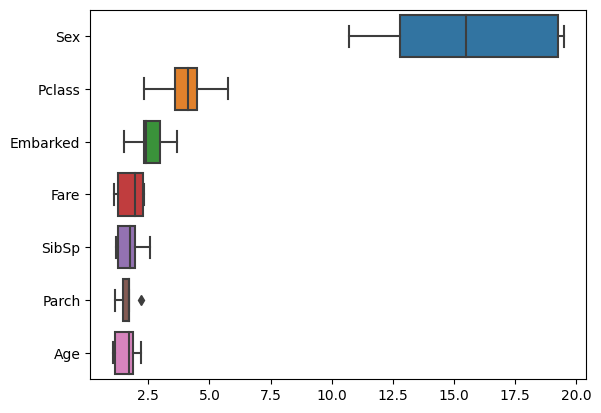

In [15]:
# 特徴量重要度
# XGBoostではmodel.get_score(importance_type='gain')で特徴重要度が取得できる
# 戻り値はdict形式なのでDataFrameに変換する
feature_importances = []
for _, model in models:
    score_dict = model.get_score(importance_type="gain")
    # 全ての列についてスコアがない場合は0で補完する
    row = [score_dict.get(col, 0.0) for col in USE_COL]
    feature_importances.append(row)

feature_importances_df = pd.DataFrame(feature_importances, columns=USE_COL)

order = feature_importances_df.mean().sort_values(ascending=False).index.tolist()
sns.boxplot(data=feature_importances_df, orient="h", order=order)

In [19]:
# テストデータに対する予測
dtest = xgb.DMatrix(
    test[USE_COL].to_pandas(),
    feature_names=USE_COL,
    enable_categorical=True
)
pred = []
for _, model in models:
    p = model.predict(dtest, iteration_range=(0, model.best_iteration+1))
    pred.append(p)
pred = np.mean(pred, axis=0)
pred = (pred > 0.5).astype(int)

# predに推論結果が入っている
pred


array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1])